# Projet Final - Classification binaire

- **Description du projet :**

> Ce projet consiste à prédire le parti politique gagnant des élections présidentielles de 2020 aux États-Unis à partir des données socio-démographiques.

![US](https://prod-media-eng.dhakatribune.com/uploads/2020/06/bigstock-illustration-of-election-357906857-1592827070539.jpg)

Dans cette partie de `modélisation` et `d'évaluation` nous allons prendre en compte les conclusions faites dans la précendente partie d'`exploration de données` afin de bien définir les modalités de `modélisation`. Il tient à noter que nous `évaluerons` nos `modèles` avec la `métrique` de `Score F1`

## Table de matières
<ol>
    <li><a href="#def">Définition du problème</a></li>
    <li><a href="#import_data">Importation et acquisition de données</a>
        <ol>
            <li><a href="#import">Importation des librairies</a></li>
            <li><a href="#get_data">Acquisition de données</a></li>
        </ol>
    </li>
    <li><a href="#outlier">Supression des outliers</a></li>
    <li><a href="#feat_engin">Feature Engineering</a></li>
    <li><a href="#model">Construction de modèle</a>
        <ol>
            <li><a href="#pipeline">Pipeline</a></li>
            <li><a href="#hyperparams">Optimisation des hyperparamètres et évaluation</a></li>
        </ol>
    </li>
    <li><a href="#expli">Explicabilité de modèle</a>
        <ol>
            <li><a href="#globale">Analyse de l'importance des variables globales</a></li>
            <li><a href="#locale">Analyse de l'importance des variables locales</a></li>
        </ol>
    </li>
</ol>

<a id="def"></a>
## 1. Définition du problème

- L'objectif est de *`prédire` le parti politique victorieux de chaque état U.S aux élections de 2020 en fonction d'un ensemble de données socio-démographiques et d'évaluer la performance du `modèle`.*

- Nous avons à notre disposition plusieurs jeux de données, notamment ceux des résulatats entre 2008 et 2016 et également ceux de 2020 mais les prédictions se feront uniquement avec le `Dataset` des élections de `2020`.

- Nous partirons de rien et essayer de construire progressivement une solution atteignant une très bonne performance.

- Il s'agit bien d'un problème de *`Machine Learning Supervisé`* et plus précisement d'une tâche de *`classification binaire`* dont l'objectif est de prédire une variable `qualitative discrète` : *`Parti Républicain (1)`* ou *`Parti Démocrate (0)`.*

- Le `modèle` sera évalué en utilisant la métrique de *`Score F1`* qui est le rapport entre deux métriques *`Precision`* et  *`Recall`* mais nous utiliserons également d'autres `métriques` comme le `Recall`, la `Precision` et l'`accuracy` pour évaluer le modèle afin comparer leurs performances.

<a id="import_data"></a>
## 2. Importation des packages nécessaires et acquisition de données

<a id="import"></a>
## 2.1 Importation des packages nécessaires au travail

In [1]:
# Packages de manipulation des tableaux et DataFrames
import numpy as np
import pandas as pd

# Package pour la réprésentation graphique
import plotly.express as px

# Packages pour l'analyse statistique
import scipy.stats as ss

# Pour gérer les expressions régulières
import re

# Package xgboost
from xgboost import XGBClassifier

# Packages scikit-learn pour la modélisation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score

# Package pour interpréter les modèles
import shap

<a id="get_data"></a>
## 2.2 Acquisition des données

In [2]:
# Afficher toutes les colnnes de nos DataFrames
pd.set_option('display.max_columns', None)

In [3]:
# Charger les données dans le notebook
df_election = pd.read_csv("elections.csv")

In [4]:
# Afficher la taille des données de train
print(f"La base fait {df_election.shape[0]} et {df_election.shape[1]} colonnes")
# Afficher les 5 premières lignes de nos données
df_election.head()

La base fait 3111 et 354 colonnes


,state_name,fips_code,county_name,votes_gop,votes_dem,total_votes,diff,per_gop,per_dem,per_point_diff,win,county,total_2008,dem_2008,gop_2008,oth_2008,total_2012,dem_2012,gop_2012,oth_2012,total_2016,dem_2016,gop_2016,oth_2016,State_x,Area_Name,Rural-urban_Continuum Code_2003,Rural-urban_Continuum Code_2013,Urban_Influence_Code_2003_x,Urban_Influence_Code_2013_x,Economic_typology_2015,CENSUS_2010_POP,ESTIMATES_BASE_2010,POP_ESTIMATE_2010,POP_ESTIMATE_2011,POP_ESTIMATE_2012,POP_ESTIMATE_2013,POP_ESTIMATE_2014,POP_ESTIMATE_2015,POP_ESTIMATE_2016,POP_ESTIMATE_2017,POP_ESTIMATE_2018,POP_ESTIMATE_2019,N_POP_CHG_2010,N_POP_CHG_2011,N_POP_CHG_2012,N_POP_CHG_2013,N_POP_CHG_2014,N_POP_CHG_2015,N_POP_CHG_2016,N_POP_CHG_2017,N_POP_CHG_2018,N_POP_CHG_2019,Births_2010,Births_2011,Births_2012,Births_2013,Births_2014,Births_2015,Births_2016,Births_2017,Births_2018,Births_2019,Deaths_2010,Deaths_2011,Deaths_2012,Deaths_2013,Deaths_2014,Deaths_2015,Deaths_2016,Deaths_2017,Deaths_2018,Deaths_2019,NATURAL_INC_2010,NATURAL_INC_2011,NATURAL_INC_2012,NATURAL_INC_2013,NATURAL_INC_2014,NATURAL_INC_2015,NATURAL_INC_2016,NATURAL_INC_2017,NATURAL_INC_2018,NATURAL_INC_2019,INTERNATIONAL_MIG_2010,INTERNATIONAL_MIG_2011,INTERNATIONAL_MIG_2012,INTERNATIONAL_MIG_2013,INTERNATIONAL_MIG_2014,INTERNATIONAL_MIG_2015,INTERNATIONAL_MIG_2016,INTERNATIONAL_MIG_2017,INTERNATIONAL_MIG_2018,INTERNATIONAL_MIG_2019,DOMESTIC_MIG_2010,DOMESTIC_MIG_2011,DOMESTIC_MIG_2012,DOMESTIC_MIG_2013,DOMESTIC_MIG_2014,DOMESTIC_MIG_2015,DOMESTIC_MIG_2016,DOMESTIC_MIG_2017,DOMESTIC_MIG_2018,DOMESTIC_MIG_2019,NET_MIG_2010,NET_MIG_2011,NET_MIG_2012,NET_MIG_2013,NET_MIG_2014,NET_MIG_2015,NET_MIG_2016,NET_MIG_2017,NET_MIG_2018,NET_MIG_2019,RESIDUAL_2010,RESIDUAL_2011,RESIDUAL_2012,RESIDUAL_2013,RESIDUAL_2014,RESIDUAL_2015,RESIDUAL_2016,RESIDUAL_2017,RESIDUAL_2018,RESIDUAL_2019,GQ_ESTIMATES_BASE_2010,GQ_ESTIMATES_2010,GQ_ESTIMATES_2011,GQ_ESTIMATES_2012,GQ_ESTIMATES_2013,GQ_ESTIMATES_2014,GQ_ESTIMATES_2015,GQ_ESTIMATES_2016,GQ_ESTIMATES_2017,GQ_ESTIMATES_2018,GQ_ESTIMATES_2019,R_birth_2011,R_birth_2012,R_birth_2013,R_birth_2014,R_birth_2015,R_birth_2016,R_birth_2017,R_birth_2018,R_birth_2019,R_death_2011,R_death_2012,R_death_2013,R_death_2014,R_death_2015,R_death_2016,R_death_2017,R_death_2018,R_death_2019,R_NATURAL_INC_2011,R_NATURAL_INC_2012,R_NATURAL_INC_2013,R_NATURAL_INC_2014,R_NATURAL_INC_2015,R_NATURAL_INC_2016,R_NATURAL_INC_2017,R_NATURAL_INC_2018,R_NATURAL_INC_2019,R_INTERNATIONAL_MIG_2011,R_INTERNATIONAL_MIG_2012,R_INTERNATIONAL_MIG_2013,R_INTERNATIONAL_MIG_2014,R_INTERNATIONAL_MIG_2015,R_INTERNATIONAL_MIG_2016,R_INTERNATIONAL_MIG_2017,R_INTERNATIONAL_MIG_2018,R_INTERNATIONAL_MIG_2019,R_DOMESTIC_MIG_2011,R_DOMESTIC_MIG_2012,R_DOMESTIC_MIG_2013,R_DOMESTIC_MIG_2014,R_DOMESTIC_MIG_2015,R_DOMESTIC_MIG_2016,R_DOMESTIC_MIG_2017,R_DOMESTIC_MIG_2018,R_DOMESTIC_MIG_2019,R_NET_MIG_2011,R_NET_MIG_2012,R_NET_MIG_2013,R_NET_MIG_2014,R_NET_MIG_2015,R_NET_MIG_2016,R_NET_MIG_2017,R_NET_MIG_2018,R_NET_MIG_2019,State_y,Area name,2003 Rural-urban Continuum Code,2003 Urban Influence Code,2013 Rural-urban Continuum Code,2013 Urban Influence Code,"Less than a high school diploma, 1970","High school diploma only, 1970","Some college (1-3 years), 1970","Four years of college or higher, 1970","Percent of adults with less than a high school diploma, 1970","Percent of adults with a high school diploma only, 1970","Percent of adults completing some college (1-3 years), 1970","Percent of adults completing four years of college or higher, 1970","Less than a high school diploma, 1980","High school diploma only, 1980","Some college (1-3 years), 1980","Four years of college or higher, 1980","Percent of adults with less than a high school diploma, 1980","Percent of adults with a high school diploma only, 1980","Percent of adults completing some college (1-3 years), 1980","Percent of adults completing four years of college or higher, 1980","Less than a high school diploma, 1990","High school diploma only, 1990","Some

- **Affichage de la distribution de la target avant de stratifier les données**

In [5]:
# Afficher répartition distributive de la target
df_election["win"].value_counts(normalize=True)

1    0.827387
0    0.172613
Name: win, dtype: float64

<a id="outlier"></a>
## 3. Suppression des valeurs aberrantes

In [6]:
# Définir la fonction de suppression de valeurs aberrantes
def remove_outliers(df, column_name):

    """
    Cette foncion permet de supprimer les valeurs aberrantes potentilles se trouvant
    dans un DataFrame et de renvoyer un nouveau DataFrame sans valeurs aberrantes

    Inputs:

    df         : Le DataFrame avec sur lequel on souaite supprimer les valeurs aberrantes
    column_name: Le nom de la colonne qu'il faut vérifier les lignes des outliers potentiels

    Returns:

    Renvoyer le DatFrame (df) qui ne contient aucune valeur aberrante

    """

    # Calculer le 1er et le 3ème quartiles
    Q1, Q3 = df[column_name].quantile([0.25, 0.75])
    # Calculer l'écart interquartile (IQR)
    IQR = Q3 - Q1

    # Calculer les limites inférieures et supérieures
    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)
    
    # Supprimer les lignes qui contiennent les outliers potentiels
    # Des lignes se situant entre les limites inférieures et supérieures
    df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

    # Renvoyer le DataFrame sans valeurs aberrantes
    return df

In [7]:
# Créer la matrice de variables explicatives
X = df_election.drop(columns=["win"])
# Créer la liste des colonnes numériques
num_cols = X.select_dtypes(include=np.number).columns.tolist()

In [8]:
# Faire appel à la fonction pour supprimer les outliers
for col in num_cols:

    # Supprimer les outliers de chaque colonne numérique
    remove_outliers(X, col)

- **Création de la target à partir des données sans outliers**

In [9]:
# Créer la target
X["win"] = np.where(X["votes_gop"] > X["votes_dem"],
                                 1, 0).astype(np.int64)

- **Sélection des variables des dernières années et celles jugées pertinentes vue métier**

In [10]:
cols_to_keep = ["county", "Economic_typology_2015", "POP_ESTIMATE_2019", "gop_2012", "dem_2012",
                "N_POP_CHG_2019", "Deaths_2019", "R_NATURAL_INC_2019", "PCTPOVALL_2019", "dem_2016",
                "gop_2016", "GQ_ESTIMATES_2019", "2013 Urban Influence Code", 
                "Unemployment_rate_2019", "R_DOMESTIC_MIG_2019", "Percent of adults with a bachelor's degree or higher, 2015-19",
                "Med_HH_Income_Percent_of_State_Total_2019", "Metro_2013", "win"]

In [11]:
# Sélectionner un sous-ensemble de colonnes sur lesquelles travailler
df_final = X[cols_to_keep].copy()

In [12]:
# Vérifier les modifications apportées
print(f"La nouvelle base fait {df_final.shape[0]} lignes et {df_final.shape[1]} colonnes")
# Afficher les 5 premières lignes des données sélectionnées
df_final.head()

La nouvelle base fait 3111 lignes et 19 colonnes


,county,Economic_typology_2015,POP_ESTIMATE_2019,gop_2012,dem_2012,N_POP_CHG_2019,Deaths_2019,R_NATURAL_INC_2019,PCTPOVALL_2019,dem_2016,gop_2016,GQ_ESTIMATES_2019,2013 Urban Influence Code,Unemployment_rate_2019,R_DOMESTIC_MIG_2019,"Percent of adults with a bachelor's degree or higher, 2015-19",Med_HH_Income_Percent_of_State_Total_2019,Metro_2013,win
0,Autauga County,0.0,55869,17366,6354,336.0,541.0,1.490099,12.1,5908,18110,455.0,2.0,2.7,4.847310,26.571573,112.481888,1.0,1
1,Baldwin County,5.0,223234,65772,18329,5379.0,2326.0,-0.099753,10.1,18409,72780,2170.0,2.0,2.7,24.017829,31.862459,115.645828,1.0,1
2,Barbour County,3.0,24686,5539,5873,-186.0,312.0,-2.259978,27.1,4848,5431,2812.0,6.0,3.8,-5.690302,11.578713,69.482918,0.0,1
3,Bibb County,0.0,22394,6131,2200,27.0,252.0,-0.536181,20.3,1874,6733,2148.0,1.0,3.1,1.385134,10.378526,92.557610,1.0,1
4,Blount County,0.0,57826,20741,2961,55.0,657.0,-0.103809,16.3,2150,22808,489.0,1.0,2.7,1.020788,13.093413,102.184624,1.0,1


<a id="feat_engin"></a>
## 4. Feature Engineering

- **Création du parti gagnant de chaque année entre 2012 et 2016**

In [13]:
# Créer le parti gagnant de 2012
df_final["win_12"] = np.where(df_final["gop_2012"] > df_final["dem_2012"],
                                 1, 0).astype(np.int64)
# Créer parti gagnant de 2016
df_final["win_16"] = np.where(df_final["gop_2016"] > df_final["dem_2016"],
                                 1, 0).astype(np.int64)

- **Suppression des variables servi à la création de chaque parti gagnant**

In [14]:
# Supprimer les variables
df_final.drop(columns=["gop_2012", "gop_2016", "dem_2012", "dem_2016"], 
                 inplace=True)

- **Division des données en jeu d'entrainement et de test**

In [15]:
# Définir la valeur de la seed
SEED = 42
# Stratifier les données sur a la target
df_train, df_test = train_test_split(df_final, test_size=0.20,
                                     random_state=SEED, stratify=df_final["win"]
                                     )

- **Affichage de la distribution de la target après la stratification de données**

In [16]:
# Distribution des données de train set
df_train["win"].value_counts(normalize=True)

1    0.827572
0    0.172428
Name: win, dtype: float64

In [17]:
# Distribution des données de test set
df_test["win"].value_counts(normalize=True)

1    0.826645
0    0.173355
Name: win, dtype: float64

<a id="model"></a>
## 5. Construction du modèle

Dans cette partie de construction du 1er modèle de machine learning, nous allons entrainer quatre différents modèles et retenir celui qui généralise le mieux afin de construire le modèle final sur celui retenu en terme de bonnes performances.

- **Division des jeux de train et test en matrices vecteurs**

In [18]:
# Créer la matrice de train set
X_train = df_train.drop(columns=["win"])
# Créer le vecteur de train set
y_train = df_train["win"]

# Créer la matrice de test et le vecteur de test
X_test = df_test.drop(columns=["win"])
y_test = df_test["win"]

- **Création des listes de variables par catégorie**

In [19]:
# Créer la liste des variables numériques
num_cols = X_train.select_dtypes(include=np.number).columns.tolist()
# Créer la liste des variables catégorielles
cat_cols = X_train.select_dtypes(exclude=np.number).columns.tolist()
# Créer la liste de toutes les variables
all_cols = X_train.columns.tolist()

<a id="pipeline"></a>
## 5.1 Pipeline pour entrainer les modèles sélectionnés

Pour construire nos modèles nous avons choisis d'utiliser des **`Pipelines`** pour faire ces différents traitements :

- **`Imputation` de valeurs manquantes** numériques par la médiane et catégorielles par la modalité "`missing`".
- **`Encodage` de variables catégorielles** avec le **`One-Hot Encoder`**.
- **`Normalisation` des variables** avec le **`RobustScaler`**.

***Pour rapel, le `Data Preprocessing` (Pré-Traitement de données) :***

C'est une opération ou une étape *`très capitale`* qui consiste à transofomer les données pour les mettre dans un format propice au développement d'un **`modèle`** de ***`Machine Learning`***

Ensuite, nous entraînerons plusieurs modèles afin de retenir celui qui présentes des meilleurs performance en terme du **`Score de F1`**.

- **Définition de la fonction d'entraînement des modèles**

In [20]:
# Définir la fonction pour entrainer les modèles
def fit_model(estimator, X_train, y_train, **kwargs):
    """Cette fonction permet d'entrainer un modèle de Machine Learning en fonction
       de l'estimateur, les données d'entrainement  et renvoi un modèle entrainé

    Args:
        estimator (Classifieur): C'est l'estimateur qu'il faut utiliser 
        X (DataFrame): Les données d'explicatives d'entrainement
        y (Vecteur): Le vecteur explicatif d'entrainement

    Returns:
        Classifieur: Le modèle entrainé
    """

    # Séparer les colonnes numériques et catégorielles
    num_cols = X_train.select_dtypes(include=np.number).columns
    cat_cols = X_train.select_dtypes(exclude=np.number).columns
    
    # Traiter les variables numériques
    num_pipeline = make_pipeline(
        SimpleImputer(strategy='median'),
        RobustScaler()
    )
    # Traiter les variables catégorielles
    cat_pipeline = make_pipeline(
        SimpleImputer(strategy='constant', fill_value='missing'),
        OneHotEncoder(handle_unknown='ignore')
    )
    # Combiner les deux pipelines 
    preprocessor = make_column_transformer(
        (num_pipeline, num_cols),
        (cat_pipeline, cat_cols)
    )
    # Construire le modèle
    model = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("estimator", estimator)
        ]
    )
    # Renvoyer un modèle construit et entrainé
    return model.fit(X_train, y_train, **kwargs)

- **Définition de la fonction d'évaluation des modèles**

In [21]:
# Définir la fonction d'évaluation des modèles
def model_evaluation(model, X_train, y_train, X_test, y_test):
    """Cette fonction permet d'évaluer la performance d'un modèle

    Args:
        model (Classifieur): L'estimateur à utiliser pour évaluer le modèle
        X_train (DataFrame): Les données explicative d'entrainement
        y_train (Vecteur): Le vecteur target d'entrainement
        X_test (DataFrame): Les données explicatives de test
        y_test (Vecteur): Le vecteur target de test

    Returns:
        float: Ce sont les scores f1 de train et de test qui sont renvoyés
    """

    # Prédir sur les jeux de données de train et de test
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculer le Score F1 sur les deux jeux de données
    f1_train = f1_score(y_train, y_train_pred)
    f1_test = f1_score(y_test, y_test_pred)

    # Renvoyer le Score F1 de chaque jeu
    return f1_train, f1_test

- **Définir le dictionnaire des modèles a entrainer**

In [22]:
# Dictionnaire des modèles à entraîner
models = {
    "LogisticRegression":
    LogisticRegression(
        max_iter=1000,
        random_state=SEED
    ),
    "SVM":
    svm.SVC(
        kernel="linear"
    ),
    "XGBClassifier":
    XGBClassifier(
        n_estimators=80,
        eval_metric='logloss',
        random_state=SEED
    ),
    "RandomForestClassifier":
    RandomForestClassifier(
        n_estimators=400,
        max_depth=3,
        random_state=SEED
    )
}

- **Parcourir le dictionnaire des modèles**

In [23]:
# Boucler sur chacun des modèles
for model_name, model in models.items():

    # Entrainer le model
    fit_m = fit_model(model, X_train, y_train)

    # Calculer les scores f1 du train et de test
    evaluation = model_evaluation(fit_m, X_train, y_train, X_test, y_test)

    # Afficher pour chaque modèle les scores f1 de train et de test
    print(f"Score F1 {model_name :-<30} : {round(evaluation[0], 4)} (train)",
          f"{round(evaluation[1], 4)} (test)"
          )

Score F1 LogisticRegression------------ : 0.9887 (train) 0.9913 (test)
Score F1 SVM--------------------------- : 0.9942 (train) 0.9903 (test)
Score F1 XGBClassifier----------------- : 1.0 (train) 0.9923 (test)
Score F1 RandomForestClassifier-------- : 0.9057 (train) 0.9051 (test)


Le **`XGBoost`** et la **`Forêt Aléatoire`** présentent de très bonnes performances en terme du `score f1` sur le jeu de `test`.

La `Régression Logistique`performe également bien en apparence mais présente un sous-apprentissage.

La **`Forêt Aléatoire`** apparaît plus robuste car l'écart de performance entre le `score f1` `train` et `score f1` `test` est très faible. Ce qui signifie que le modèle est facilement généralisable sur de nouveaux jeux de données par rapport aux autres modèles qui ont des performances qui chutent entre le train et le test. 

Donc, nous poursuivrons avec le modèle **[RandomForest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)** afin de mettre en oeuvre les techniques de sélection d'hyperparamètres.

<a id="hyperparams"></a>
## 5.2 Optmisation des hyperparamètres et évaluation du modèle final

In [24]:
# Définir la dictionnaire d'hyperparamètres
params_grid = {"n_estimators" : [300, 700, 1000],
               "max_depth" : [3, 5, 6],
              }
              
# Instancier l'estimateur
rfc = RandomForestClassifier(
    max_features="sqrt", 
    random_state=SEED
    )

# Rechercher les meilleurs hyperparamètres
grid_search_cv = GridSearchCV(
    estimator=rfc,
    param_grid=params_grid,
    scoring="f1",
    n_jobs=-1,
    cv=5,
    verbose=2
)

In [25]:
# Entrainer le modèle
random_model = fit_model(grid_search_cv, X_train, y_train)

# Evaluer le modèle
evaluation = model_evaluation(random_model, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [26]:
# Afficher les résultats des performances
print(f"Nous obtenons : {round(evaluation[0], 4)} (train)",
      f"{round(evaluation[1], 4)} (test)")

Nous obtenons : 0.9321 (train) 0.9279 (test)


<a id="expli"></a>
## 6. Explicabilité de modèle

<a id="globale"></a>
## 6.1 Analyse de l'importance des variables globales

L'importance `globale` des variables permet de répresenter les varibles selon leur contribution à la participation de construction du modèle.

In [27]:
# Récupérer le meilleur classifieur
best_random_model = random_model.named_steps.estimator.best_estimator_

# Récupérer l'importance des variables
importance = best_random_model.feature_importances_

In [28]:
one_hot_features = (
    random_model
    .named_steps
    .preprocessor
    .named_transformers_['pipeline-2']
    .named_steps['onehotencoder']
    .get_feature_names_out(cat_cols)
).tolist()

# Créer la liste des colonnes
features_cols = num_cols + one_hot_features

# Créer le dataframe qui contient l'importance des variables
feature_importance = (
    pd.DataFrame(
        {"features_cols": features_cols, "importance": 100 * importance}
    )
    .sort_values(["importance"], ascending=False)
    .reset_index(drop=True)
)

# Afficher les 5 premières lignes du DataFrame
feature_importance.head()

,features_cols,importance
0,win_12,14.999970
1,win_16,13.954077
2,POP_ESTIMATE_2019,8.051540
3,Percent of adults with a bachelor's degree or ...,7.782261
4,GQ_ESTIMATES_2019,6.606475


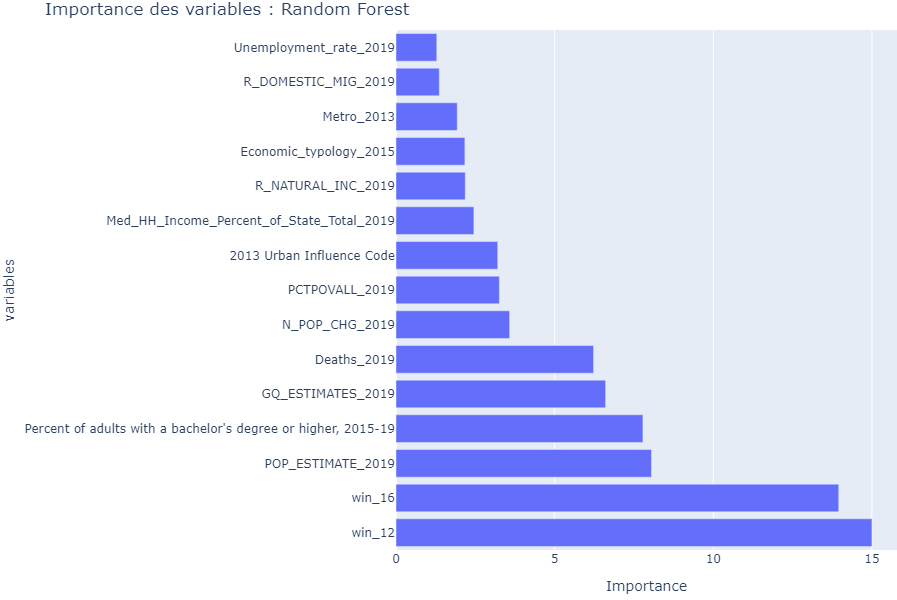

In [29]:
# Représenter les 15 variables les plus importantes
fig = px.bar(feature_importance[0:15],
             y="features_cols", x="importance",
             hover_data={'importance': ':.2f'}
             )

fig.update_layout(
    title="Importance des variables : Random Forest",
    xaxis_title="Importance",
    yaxis_title="variables",
    margin=dict(l=0, r=0, t=30, b=50),
    width=900, height=600
)

# Afficher le graphique
fig.show()

<a id="locale"></a>
## 6.2 Analyse de l'importance des variables locales

In [31]:
# Appliquer le preprocessing des données sur la matrice X_test
X_test_prepro = random_model.named_steps.preprocessor.transform(X_test)

# Transformez la sortie préprocessée en dataframe
# en indiquant bien le nom des colonnes
X_test_prepro = pd.DataFrame(
    data=X_test_prepro,
    columns=features_cols
)

# Vérifier les résulats du DataFrame crée
X_test_prepro.head()


ValueError: Shape of passed values is (623, 1), indices imply (623, 1565)

> Pour des raisons de non exécution du code, je n'ai pas pu mettre le code d'analyse de l'importance de variables locales, car je n'ai pas non seulement été capable de résoudre cette erreur que j'ai renconté mais aussi, il faut souligner que cela fait partie du jeu.
>
>Il faut être honête et savoir dire que l'on ne peut afin d'avoir l'aide.
Donc, je n'ai pas été capable de faire cette analyse et donc j'ai jugé bon de ne pas présenter le code qui n'exécutait pas.
C'est dans cette dynamique que je me remets entièrement à vous, pour que vous me donnez des pistes nécessaires afin d'avancer, merci !